## Table of Contents

1. [Business Understanding](#business-understanding)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [Deployment](#deployment)
7. [Exploratory Data Analysis](#eda)

## Business Understanding <a name="business-understanding"></a>

For this study, we will analyze serious crimes commited in Los Angeles for the period 2020 - 2023 according to the national crime index.

There are 2 objectives for this study:
1) Analyze serious crimes committed in Los Angeles, accroding to the National Crime Index
2) Predict the clearance rate of serious crimes in Los Angeles to improve law enforcement outcomes and increase public safety

Low crime clearance rates are a major concern for the Police and the public. The clearance rate is the proportion of crimes that result in an arrest. 

Assess the current situation:
- What are trends in serious crimes being committed in Los Angeles today?
- What is the current clearance rate for serious crimes in Los Angeles?

Determining Data Mining Goals:
- Insure that the crime incidents are appropriately labeled according to national crime index
- Analyze impact to citizens as far as demographics, time of day, and location

Project Plan for this study:
- Collect the data from the LAPD public data sharing portal
- Preprocess the data to ensure that it is clean and ready for analysis
- Analyze the data to understand the trends in serious crimes in Los Angeles
- Clean the data improving data quality, improving analysis insights and model performance
- Create machine learning pipelines to pre-process the data and train the model
- Evaluate the model to ensuring it's performance is accurate and interpretable


## Data Understanding <a name="data-understanding"></a>

The data we collected from the LAPD includes the following observations:
- 932,140 crimes reported
- 21 different regional police districts
- 120 unique labels classifying different crimes reported
- 79 unique labels classifying different weapons used in the crimes reported
- 306 unique labels classifying different locations where crimes were committed
- 6 unique labels for crime status (arrest made, investigation continues)
- Time Period - Full year data for 2020 - 2023 and Q1 for 2024

There are 27 (omitting crime ID field) features included in the data cover the following topics:
<br>
- Date, Time, Location and Description of each crime comitted
- Victim demographics (Age, Sex, Descent)
- Type of location where crimes are committed (Apartment, Gas Station, etc)
- Weapon used in the crime (Firearm, Knife, etc)
- Status of the crime (Arrest made or continued investigation)
- Geolocation

### Data Quality
The data quality is ok in general.  The critical features appear to be in good shape, with a negligble amount of missing values.  There is an issue with the `Part1-2`, label.  The LAPD decided to label crimes in accordance with the the newer NIBRS system.  National crime data is still analyzed based on an older UCR SRS standard.  I will need to convert the `Part1-2` label to the UCR SRS standard to ensure that the data can be analyzed in accordance with the national crime index.


## Data Preparation <a name="data-preparation"></a>
We will take the following steps to create a high quality dataset

1. Drop erroneous columns - Columns `CrmCd2`, `CrmCd3`, `CrmCd4` have between 95% - 99% missing values. We will drop these columns as they do not provide any valuable insight.<br><br>
2. Temporal data - We will need to manually format date and time columns, including `DateRptd`,`DATEOCC`,`TIMEOCC`<br><br>
3.  There is an issue with the data in `TIMEOCC`, where they use the 24 hour time format, but not for all of the values.  This will need to be repaired if time of day is used for analysis.<br><br>
4. Text and Categorical Data - We will create machine learning pipelines using TFIDF to vectorize the text data and one hot encoding to transform the categorical data

### Feature Engineering
We will add the following features to improve data quality for more granular analysis:
- `Year` - Extract year from `DATEOCC`
- `Month` - Extract month from `DATEOCC`
- `Day` - Extract day from  `DATEOCC`
- `time_of_day` - Descritize `TIMEOCC` into 4 intervals (Morning, Afternoon, Evening, Night)
- `crime_category` - This label will be used to classify the crimes into 10 categories, according to the national crime index
- `crime type` - Label used to categorize 2 different types of crimes Propety and Violent crimes
- `cleared` - Create a binary label for the clearance rate of the crime


### Data Visualization
We will create an interactive map which shows the concentration of crime activity per region, with some written analysis to observe patterns in crime concentration.

## Modeling <a name="modeling"></a>

We will use an XGBoost predictive model to predict the clearance rate of serious crimes in Los Angeles.  We will use the following steps to create the model:

1. Create a development, training and test datasets to train the model
2. Create a machine learning pipeline to preprocess the data
3. Create a parameter grid to choose ideal hyperparameters to optimize the model


## Evaluation <a name="evaluation"></a>

The model predicted arrest outcomes with 89% accuracy.  The accuracy will need to be improved closer to 100% if the model is to be used in the field.<br>
<br>

![Confusion Matrix](/Users/danherman/Desktop/los_angeles_crime/images/cm.png)

<br>

![Train Test](/Users/danherman/Desktop/los_angeles_crime/images/train_test.png)

## Deployment <a name="deployment"></a>

Theoretically, the model can be deployed in the field, providing real time prediction for crimes, to optimize resources and improve resopnse times.

As far as tech stack, we can use the [Django framework](https://www.djangoproject.com/), which is a high-level Python web framework that encourages rapid development and clean, pragmatic design.  We can also use the [Django REST framework(DRF)](https://www.django-rest-framework.org/) to create a RESTful API for the model.  In terms of infrastructure, we can deploy the Django application on [AWS Elastic Beanstack](https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/create-deploy-python-django.html)

Please send me an email if you have any questions:  dan.herman@me.com

## Exploratory Data Analysis <a name="eda"></a>


In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# set the seaborn run command for font parameters
sns.set(rc={'font.weight': 'bold'}, font_scale=1.3)

# set parameters to remove erroenous warning messages that clutter the notebook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

### Load in the data and preprocess the columns

In [2]:
# load in crime data
data = pd.read_csv('../data/crime_data.csv')

# pre-process data columns
data.columns = data.columns.str.replace(' ', '')

# fix the formatting for date and time, include hours minutes seconds
data['DateRptd'] = pd.to_datetime(data['DateRptd'], format='%m/%d/%Y %I:%M:%S %p')
data['DATEOCC'] = pd.to_datetime(data['DATEOCC'], format='%m/%d/%Y %I:%M:%S %p')

print('There are {} observations and {} features in the dataset'.format(data.shape[0], data.shape[1]))

There are 932140 observations and 28 features in the dataset


### Subset the data into Part 1 and Part 2 crimes
Analyzing crime is very complex, for this study, we will only evaluate the Part 1 crimes.

In [3]:
# let's subset the data into part 1 and part 2 crimes to evaluate the effects separately 
part_1_crimes = data.loc[data['Part1-2']==1]
part_2_crimes = data.loc[data['Part1-2']==2]

print('There are {} observations and {} features in the Part 1 dataset'.format(part_1_crimes.shape[0], part_1_crimes.shape[1]))
print('There are {} observations and {} features in the Part 2 dataset'.format(part_2_crimes.shape[0], part_2_crimes.shape[1]))

There are 549757 observations and 28 features in the Part 1 dataset
There are 382383 observations and 28 features in the Part 2 dataset


### Difference in Year over Year Crime Rates
We will create a table, that shows the change in rate of crime for each region, year over year

In [4]:
# extract year from TIMEOCC, format day, month, year
part_1_crimes.loc[:,'Year'] = part_1_crimes.loc[:,'DATEOCC'].dt.year

# create pivot table with AREANAME as index, Year as columns and count of CrmCdDesc as values
regions = part_1_crimes.pivot_table(index='AREANAME', columns='Year', values='CrmCdDesc', aggfunc='count').reset_index()

# calculate year over year difference in crime counts
diff = regions.iloc[:,1:5].diff(axis=1).iloc[:,1:5]

# calculate the rate of change
rate = diff.div(regions.iloc[:,1:4].values).round(2)

# add AREANAME column back to rate dataframe
rate.insert(0, 'AREANAME', regions['AREANAME'])

# sort the rates by year to analyze trends
rate.sort_values(by=2021, ascending=False)

/var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/ipykernel_91039/1743651945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part_1_crimes.loc[:,'Year'] = part_1_crimes.loc[:,'DATEOCC'].dt.year


Year,AREANAME,2021,2022,2023
1,Central,0.23,0.40,-0.06
6,Hollywood,0.22,0.05,-0.09
12,Pacific,0.15,0.03,0.09
11,Olympic,0.15,0.12,-0.02
10,Northeast,0.11,0.07,-0.03
2,Devonshire,0.09,0.10,0.03
16,Topanga,0.09,0.06,0.10
8,N Hollywood,0.09,-0.01,0.07
13,Rampart,0.07,0.12,0.12
15,Southwest,0.06,0.11,0.08


### Plot 2021 Change in Crime Rates

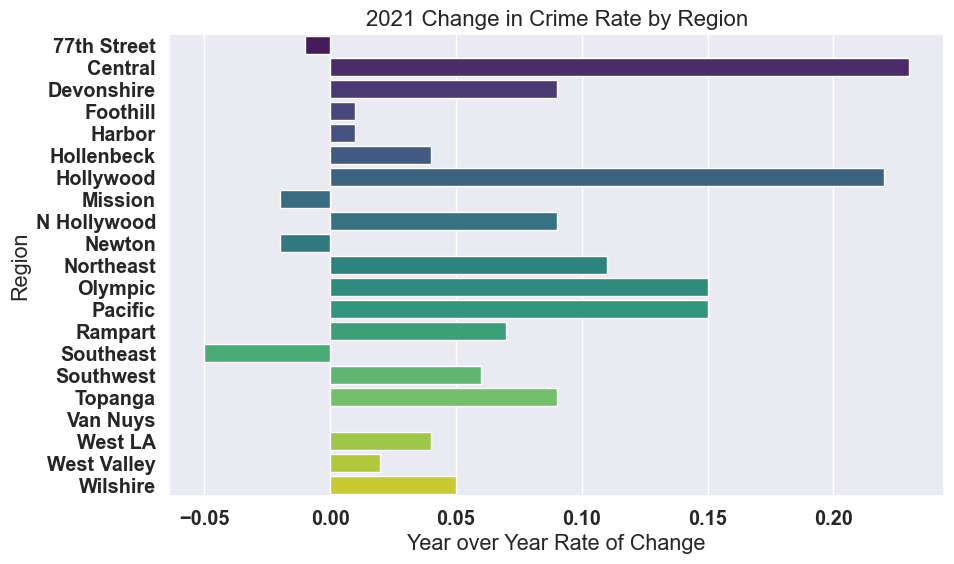

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=2021, y='AREANAME', hue='AREANAME', data=rate, ax=ax, palette='viridis')
plt.title('2021 Change in Crime Rate by Region', fontsize=16)
plt.xlabel('Year over Year Rate of Change')
plt.ylabel('Region')
plt.show()


### Plot 2022 Change in Crime Rates

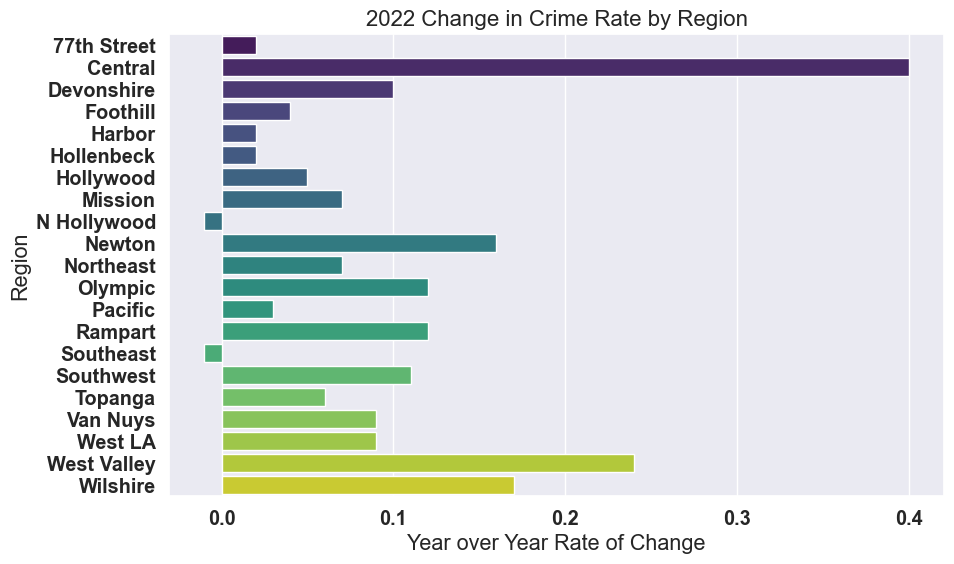

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=2022, y='AREANAME', hue='AREANAME', data=rate, ax=ax, palette='viridis')
plt.title('2022 Change in Crime Rate by Region', fontsize=16)
plt.xlabel('Year over Year Rate of Change')
plt.ylabel('Region')
plt.show()


### Plot 2023 Change in Crime Rates

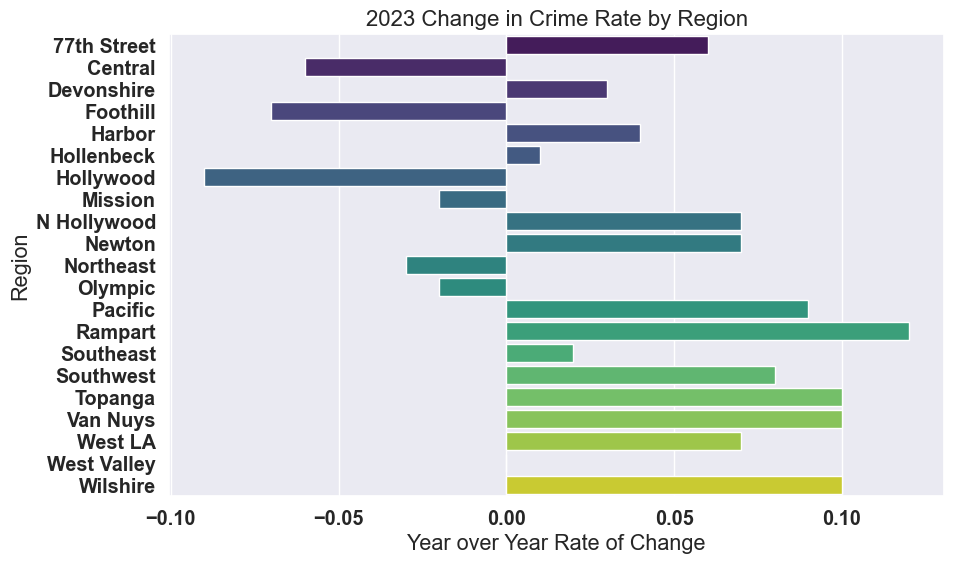

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=2023, y='AREANAME', hue='AREANAME', data=rate, ax=ax, palette='viridis')
plt.title('2023 Change in Crime Rate by Region', fontsize=16)
plt.xlabel('Year over Year Rate of Change')
plt.ylabel('Region')
plt.show()


In [10]:
data.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON'],
      dtype='object')

In [12]:
# extract year from DATEOCC, format day, month, year
data.loc[:,'Year'] = data.loc[:,'DATEOCC'].dt.year

data.groupby(['AREANAME','Year'])['CrmCdDesc'].count().to_frame()

CrmCdDesc
AREANAME    Year           
77th Street 2020      13327
            2021      13088
            2022      14554
            2023      13904
            2024       3480
...                     ...
Wilshire    2020       9286
            2021       9744
            2022      11150
            2023      11664
            2024       2909

[105 rows x 1 columns]

### Create an Interactive Chloropleth Map
These maps are quite challenging to build and there is minimal documentation available.<br>
I found a good tutorial that can serve as a companion, reviewing 3 different types of maps<br>
[Interactive Maps Tutorial](https://medium.com/geekculture/three-ways-to-plot-choropleth-map-using-python-f53799a3e623) <br>

We will use the Folium Python package.  There are 2 steps involved in building this map 
<br>
1.  Acquire the geojson data -  This data serves as the boundaries for the map and is an essential layer, where the data in the geojson file, must match the data in the dataset in the `AREANAME` column.  You can create geojson data, which is quite challenging.  Or you can look to get the file from an existing project.  If you're working on a government dataset, you can find the appropriate geojson data on GitHub <br><br>

2.  Colorscale effect - Create a dataframe with 2 columns, namely `AREANAME` and count of crimes in the region<br>
*Once again - the `AREANAME` must match the geojson data for the map to render correctly*<br>
<br>
Geojson data is widely available on GitHub.<br>


In [8]:
area_names = data.groupby('AREANAME').agg({'DateRptd':'count'}).reset_index().rename(columns={'DateRptd':'count','AREANAME':'name'})

area_names.iloc[8,0] = 'North Hollywood'
area_names.iloc[18,0] = 'West Los Angeles'

area_names

,name,count
0,77th Street,58353
1,Central,63133
2,Devonshire,38309
3,Foothill,30899
4,Harbor,38491
5,Hollenbeck,34493
6,Hollywood,49080
7,Mission,37155
8,North Hollywood,46993
9,Newton,46096


### Get the geojson file

In [9]:
#Import modules for acquiring geojson
from urllib.request import urlopen
import json

#Import geojson from Github
with urlopen('https://raw.githubusercontent.com/sidneykung/LA_crime_forecasting/main/data/LAPD_Divisions.json') as response:
    lapd_divisions = json.load(response)  #Collect geojson data from Github

In [10]:
#import folium
import folium

#Creaate a map object for choropleth map
#Set location to your location of interest (latitude and longitude )
map0 = folium.Map(location=[34.0549,-118.2426], zoom_start=10)

#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = lapd_divisions,#Assign geo_data to your geojson file
    name = "choropleth",
    data = area_names,#Assign dataset of interest
    columns = ['name','count'],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.name',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'LAPD Division').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    lapd_divisions,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['LAPD Division'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

# load the map
map0